# Task 14 - Motor Control
### Introduction to modeling and simulation of human movement
https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md

Implement a simulation of the ankle joint model using the parameters from Thelen (2003) and Elias (2014)

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import math

In [2]:
class Muscle:
    
    def __init__(self, Lslack, Lce_o, Fmax, alpha):
        
        self.Lslack = Lslack # tendon slack length
        self.Lce_o  = Lce_o # optimal muscle fiber length
        self.Fmax   = Fmax #maximal isometric DF force
        self.alpha  = alpha # DF muscle fiber pennation angle
        self.Umax = 0.04
        self.width = 0.63
        self.a = 1
    
    def tendonLength(self, Lm, Lnorm_ce):
        '''
        Compute tendon length

        Inputs:
            Lm = 
            Lce_o = optimal length of the fiber
            Lnorm_ce = normalized contractile element length

        Output:
            Lnorm_see = normalized tendon length   
        '''
        Lnorm_see = Lm/self.Lce_o - Lnorm_ce*np.cos(self.alpha)

        return Lnorm_see
    
    def TendonForce(self, Lnorm_see):
        '''
        Compute tendon force

        Inputs:
            Lnorm_see = normalized tendon length
            Lslack = slack length of the tendon (non-normalized)
            Lce_o = optimal length of the fiber

        Output:
            Fnorm_tendon = normalized tendon force

        '''

        if Lnorm_see<self.Lslack/self.Lce_o: 
            Fnorm_tendon = 0
        else: 
            Fnorm_tendon = ((Lnorm_see-self.Lslack/self.Lce_o)/(self.Umax*self.Lslack/self.Lce_o))**2

        return Fnorm_tendon
    
    def ParallelElementForce(self, Lnorm_ce):
        '''
        Compute parallel element force

        Inputs:
            Lnorm_ce = normalized contractile element length

        Output:
            Fnorm_kpe = normalized parallel element force

        '''
        Umax = 1
        
        if Lnorm_ce< 1: 
            Fnorm_kpe = 0
        else: 
            Fnorm_kpe = ((Lnorm_ce-1)/(Umax*1))**2 

        return Fnorm_kpe
    
    def ForceLengthCurve(self, Lnorm_ce):
        
        F0 = max([0, (1-((Lnorm_ce-1)/self.width)**2)])
        
        return F0
    
    def ContractileElementDot(self, F0, Fnorm_CE):
    
        '''
        Compute Contractile Element Derivative

        Inputs:
            F0 = Force-Length Curve
            Fce = Contractile element force

        Output:
            Lnorm_cedot = normalized contractile element length derivative

        '''

        FMlen = 1.4 # young adults
        Vmax = 10  # young adults
        Af = 0.25  #force-velocity shape factor

        Fnorm_CE = min(FMlen*self.a*F0 - 0.001, Fnorm_CE)

        if Fnorm_CE > self.a*F0:

            b = ((2 + 2/Af)*(self.a*F0*FMlen - Fnorm_CE))/(FMlen-1)

        elif Fnorm_CE <= self.a*F0:

            b = self.a*F0 + Fnorm_CE/Af

        Lnorm_cedot = (.25 + .75*self.a)*Vmax*((Fnorm_CE - self.a*F0)/b)

        return Lnorm_cedot
    
    def ContractileElementForce(self, Fnorm_tendon, Fnorm_kpe):
        '''
        Compute Contractile Element force

        Inputs:
            Fnorm_tendon = normalized tendon force
            Fnorm_kpe = normalized parallel element force

        Output:
            Fnorm_CE = normalized contractile element force
        '''
        Fnorm_CE = Fnorm_tendon/np.cos(self.alpha) - Fnorm_kpe
        return Fnorm_CE
    
    def activation(self, a, u, dt):
        '''
        Compute activation

        Inputs:
            u = idealized muscle excitation signal, 0 <= u <= 1
            a = muscular activation
            dt = time step

        Output:
            a = muscular activation  
        '''

        tau_deact = 50e-3 #young adults
        tau_act = 15e-3

        if u>a:
            tau_a = tau_act*(0.5+1.5*a)
        elif u <=a:
            tau_a = tau_deact/(0.5+1.5*a)

        #-------
        dadt = (u-a)/tau_a # euler

        a = a + dadt*dt
        #-------
        return a

In [3]:
Lslack = 2.4*0.09 # tendon slack length
Lce_o  = 0.09 # optimal muscle fiber length
Fmax   = 1400 #maximal isometric DF force
alpha  = 7*math.pi/180 # DF muscle fiber pennation angle

In [4]:
dorsiflexor = Muscle(Lslack = Lslack, Lce_o = Lce_o, Fmax = Fmax, alpha = alpha)

soleus = Muscle(Lslack = 0.25, Lce_o = 0.05, Fmax = 3500, alpha = 25*np.pi/180)

In [5]:
soleus.Lslack

0.25

### Muscle properties
Parameters obtained from Table 2 of Thelen (2003).

Parameters from Nigg & Herzog (2006).

Activation dynamics parameters

In [6]:
a = 1 #inital conditional for ativation
u = 1 #Initial conditional for Brain's activation
#b = .25*10#*Lce_o 

## Subject's anthropometrics
Parameters obtained experimentally or from Winter's book.

In [7]:
M      = 75 #total body mass (kg)
Lseg   = 0.26 #segment length (m)
m      = 0.0145*M #foot mass (kg)
g      = 9.81 #acceleration of gravity (m/s2)
Rcm    = Lseg*0.5 #distance from ankle joint to center of mass (m)
I      = m*(0.69*Lseg)**2 #moment of inertia
legAng = math.pi/2 #angle of the leg with horizontal (90 deg)

### Initial conditions

In [8]:
phi  = 0 #start as neutral ankle angle (0 degrees)
phid = 0 #zero velocity
Lm0  = 0.31 #initial total lenght of the muscle
Lnorm_ce = .087/Lce_o #norm
t0 = 0 #Initial time
tf = 0.5 #Final Time
h  = 1e-4 #integration step size and step counter

In [9]:
t = np.arange(t0,tf,h) # time array
# preallocating
F          = np.empty(t.shape)
phivec     = np.empty(t.shape)
Fkpe       = np.empty(t.shape)
FiberLen   = np.empty(t.shape)
TendonLen  = np.empty(t.shape)
a_dynamics = np.empty(t.shape)
Moment     = np.empty(t.shape)

## Simulation - Series

In [10]:
def momentArmDF(phi):
    '''
    Calculate the tibialis anterior moment arm according to Elias et al (2014)
    Input: 
    phi: Ankle joint angle in radians
    Output:
    Rarm: TA moment arm
    '''
    # Consider neutral ankle position as zero degrees
    phi = phi*180/np.pi # converting to degrees
    Rf = 4.3 + 1.66E-2*phi + -3.89E-4*phi**2 + -4.45E-6*phi**3 + -4.34E-8*phi**4
    Rf = Rf/100 # converting to meters
    return Rf

In [11]:
def ComputeTotalLengthSizeTA(phi):
    '''
    Calculate TA MTU length size according to Elias et al (2014)
    Input: 
    phi: ankle angle
    '''
    phi = phi*180/math.pi # converting to degrees
    Lm = 30.6 + -7.44E-2*phi + -1.41E-4*phi**2 + 2.42E-6*phi**3 + 1.5E-8*phi**4
    Lm = Lm/100
    return Lm

In [12]:
def ComputeTotalLenghtSize(Lm0, phi, Rf, Rcm):
    '''
    Inputs:
        Lm0 = initial lenght of the muscle
        Phi = degree flexion of the joint
        RF = Moment arm
        Lce_o = optimal size of the muscle
    Output:
        Lm = total muscle lenght
    '''
    Lm = Lm0 - (phi-(math.pi/2))*Rf #total muscle-tendon length from joint angle
    return Lm

In [13]:
def ComputeMomentJoint(Rf, Fnorm_tendon, Fmax, m, g, phi):
    '''
    Inputs:
        RF = Moment arm
        Fnorm_tendon = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
    Output:
        M = Total moment with respect to joint
    '''
    M = Rf*Fnorm_tendon*Fmax - m*g*Rcm*np.sin(math.pi/2 - phi)
    return M

In [14]:
def ComputeAngularAcelerationJoint(M, I):
    '''
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        phidd= angular aceleration of the joint
    '''
    phidd = M/I
    return phidd

## Simulation - Parallel

Checar os parâmetros se estão ok aqui!

In [15]:
#Normalizing


for i in range (len(t)):
    #ramp
    #if t[i]<=1:
        #Lm = 0.31
    #elif t[i]>1 and t[i]<2:
        #Lm = .31 - .04*(t[i]-1)
        #print(Lm)
        
   
    #shortening at 4cm/s
    #u = 0.7 + 0.2*np.sin(np.pi*t[i])
    
    Lm = ComputeTotalLengthSizeTA(phi)
    
    Rf = momentArmDF(phi)
    
    Lnorm_see = dorsiflexor.tendonLength(Lm, Lnorm_ce)

    Fnorm_tendon = dorsiflexor.TendonForce(Lnorm_see) 
    
    Fnorm_kpe = dorsiflexor.ParallelElementForce (Lnorm_ce)     
        
    #isometric force at Lce from CE force length relationship
    F0 = dorsiflexor.ForceLengthCurve (Lnorm_ce)
    
    Fnorm_CE = dorsiflexor.ContractileElementForce(Fnorm_tendon,Fnorm_kpe) #Fnorm_CE = ~Fm
    
    #computing activation
    a = dorsiflexor.activation(a,u,h)
    
    #calculate CE velocity from Hill's equation    
    Lnorm_cedot = dorsiflexor.ContractileElementDot(F0, Fnorm_CE)
    
    #Compute MomentJoint
    M = ComputeMomentJoint(Rf,Fnorm_tendon,Fmax,m,g,phi)
    
    #Compute Angular Aceleration Joint
    phidd = ComputeAngularAcelerationJoint (M,I)
    
    # Euler integration steps
    Lnorm_ce = Lnorm_ce + h*Lnorm_cedot
    phid= phid + h*phidd
    phi  = phi  + h*phid
    phideg= (phi*180)/math.pi #convert joint angle from radians to degree
    # Store variables in vectors
    F[i] = Fnorm_tendon*Fmax
    Fkpe[i] = Fnorm_kpe*Fmax
    FiberLen[i] = Lnorm_ce*Lce_o
    TendonLen[i] = Lnorm_see*Lce_o
    a_dynamics[i] = a
    phivec[i] = phideg
    Moment[i] = M

## Plots 

<IPython.core.display.Javascript object>


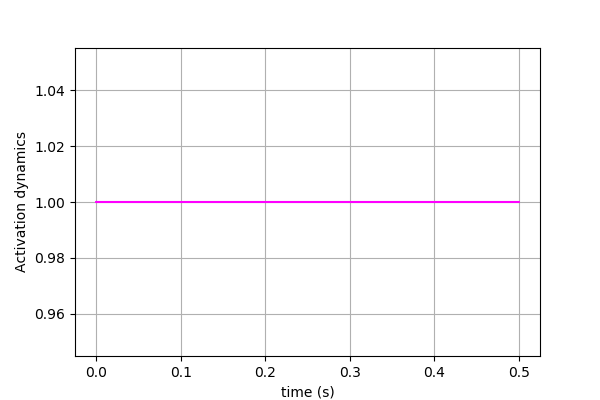

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t,a_dynamics,c='magenta')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Activation dynamics')
plt.show()

<IPython.core.display.Javascript object>


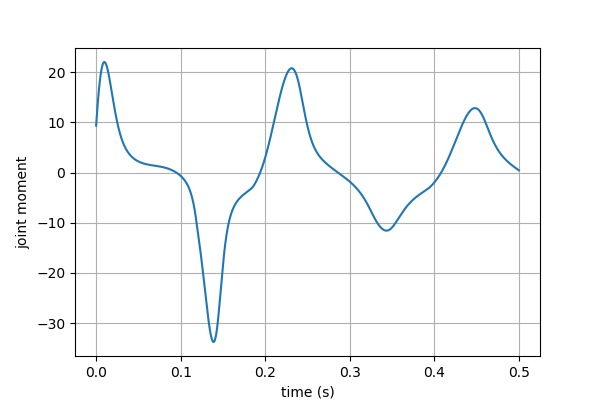

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t, Moment)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('joint moment')
plt.show()

<IPython.core.display.Javascript object>


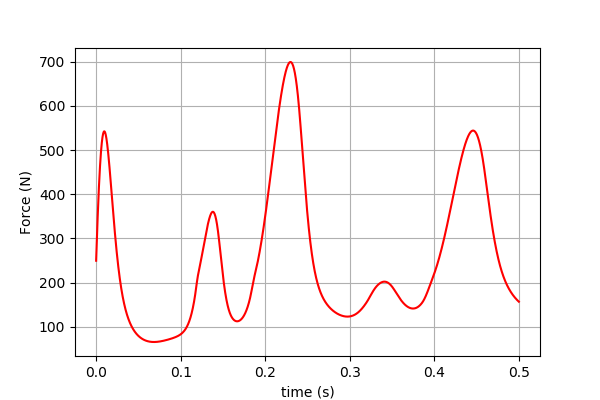

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t, F, c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)')
plt.show()

<IPython.core.display.Javascript object>


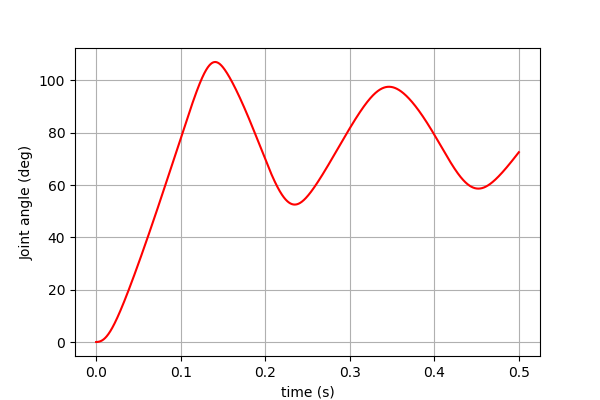

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t,phivec,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Joint angle (deg)')
plt.show()

<IPython.core.display.Javascript object>


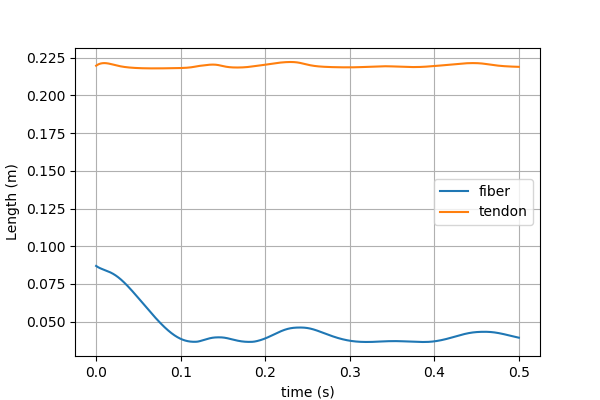

<IPython.core.display.Javascript object>


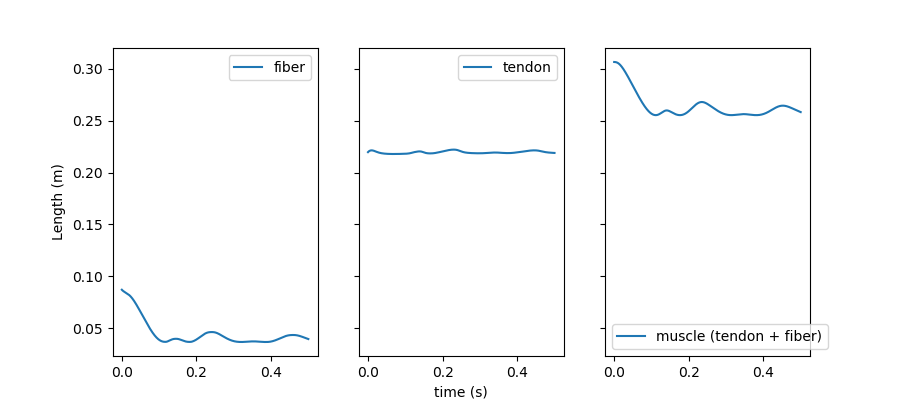

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t,FiberLen, label = 'fiber')
ax.plot(t,TendonLen, label = 'tendon')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Length (m)')
ax.legend(loc='best')


fig, ax = plt.subplots(1, 3, figsize=(9,4), sharex=True, sharey=True)
ax[0].plot(t,FiberLen, label = 'fiber')
ax[1].plot(t,TendonLen, label = 'tendon')
ax[2].plot(t,FiberLen + TendonLen, label = 'muscle (tendon + fiber)')

ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('Length (m)')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')
plt.show()